# MCMC Model Visual Diagnostics

In this section, we will introduce a suite of diagnostic plots in Orbit

- Density histogram
- Trace plot
- Pair plot

`Orbit` provides a few plotting utilities to diagnose Orbit MCMC models to examine the distribution and convergence status.

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import orbit
from orbit.models.dlt import DLTMAP, DLTAggregated, DLTFull
from orbit.diagnostics.plot import plot_posterior_params
from orbit.utils.dataset import load_iclaims

import warnings
warnings.filterwarnings("ignore")
plt.style.use('seaborn')

In [2]:
assert orbit.__version__ == '1.0.13dev'

In [3]:
# load log-transformed data
df = load_iclaims()
test_size = 52
train_df = df[:-test_size]
test_df = df[-test_size:]

response_col = 'claims'
date_col = 'week'
regressor_col = ['trend.unemploy', 'trend.filling', 'trend.job']

## Fit a Model

Before we show the diagnostic tool, we will fit a DLT model using the iclaims data.

In [4]:
dlt_mcmc = DLTFull(
    response_col=response_col,
    date_col=date_col,
    regressor_col=regressor_col,
    regressor_sign=["+", '+', '='], 
    seasonality=52,
)

Do the model training.

In [5]:
dlt_mcmc.fit(df=train_df)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


## Posterior Diagnostic Visualizations

`plot_posterior_params` is the main utility for different kinds of diagnostic plots.

### Density/Histogram

By setting `kind = 'density'`, we get posterior paramter density plot. It shows the mean, median and confidence Interval (95% by default) of various paramter posterior samples. One can specify a path string (e.g., './density.png') to save the chart.

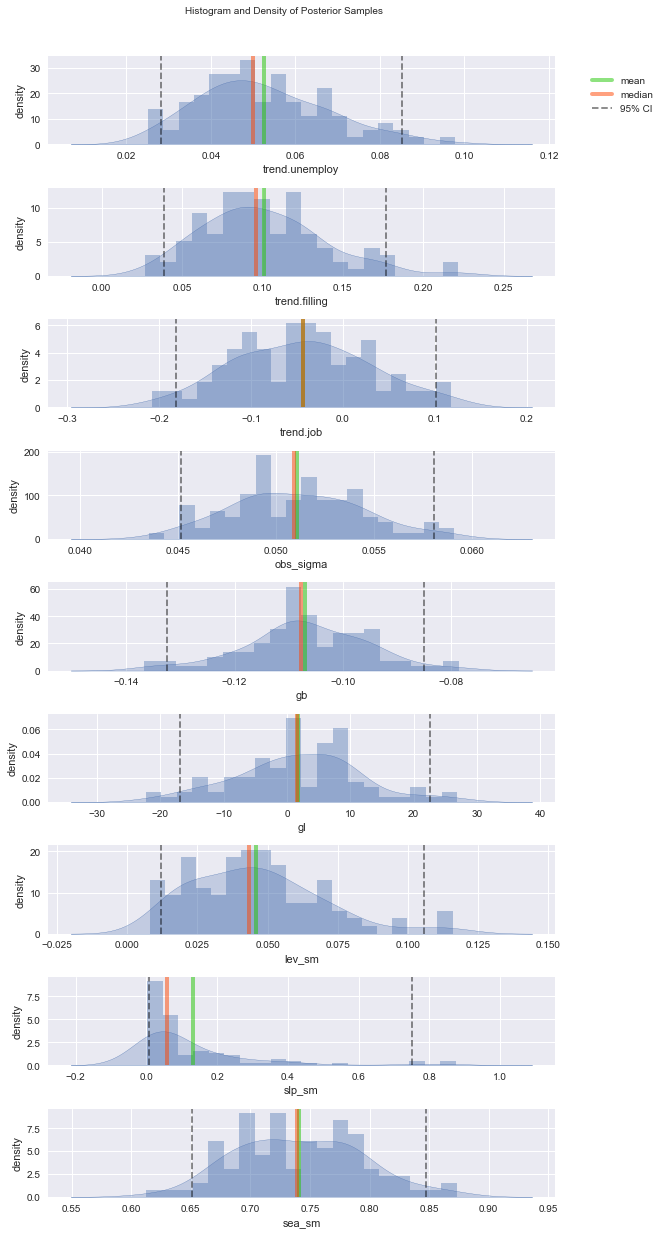

In [6]:
_ = plot_posterior_params(dlt_mcmc, kind='density',
                          incl_trend_params=True, incl_smooth_params=True)

### Trace plot

Trace plot shows the iterations of each paramter over the Markov chian sampling process. Trace plots provide an important tool for assessing mixing of a chain.

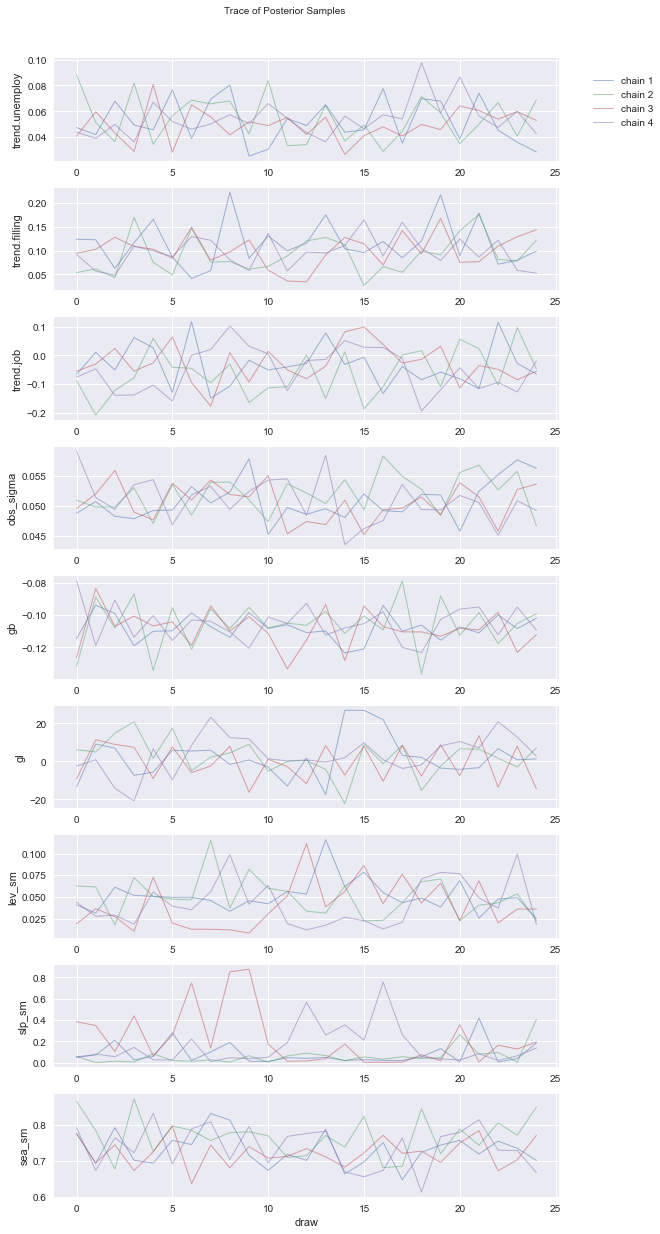

In [7]:
_ = plot_posterior_params(dlt_mcmc, kind='trace',
                          incl_trend_params=True, incl_smooth_params=True)

### pair plot
By setting `kind = 'pair'`, it will generates a series of pair plots, which depict the relationship between every two parameters.

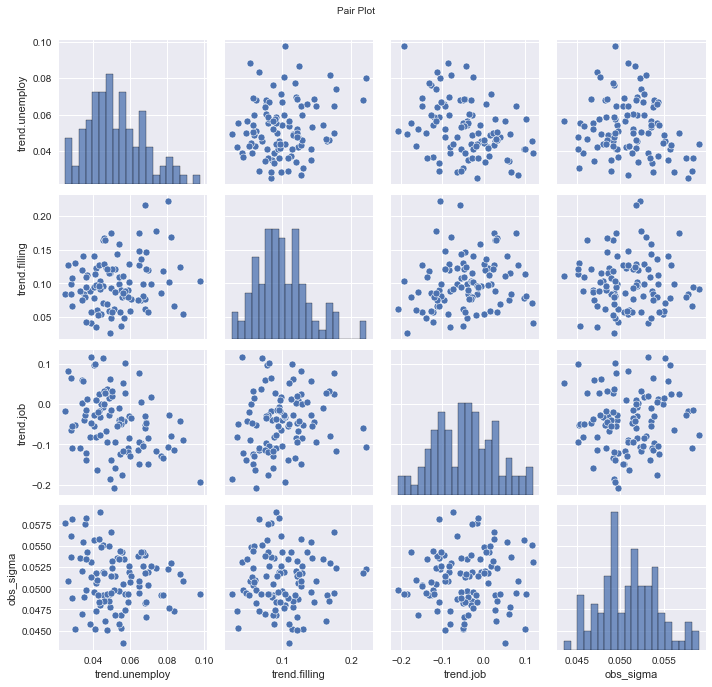

In [8]:
_ = plot_posterior_params(dlt_mcmc, kind='pair', pair_type='scatter', 
                          incl_trend_params=False, incl_smooth_params=False)

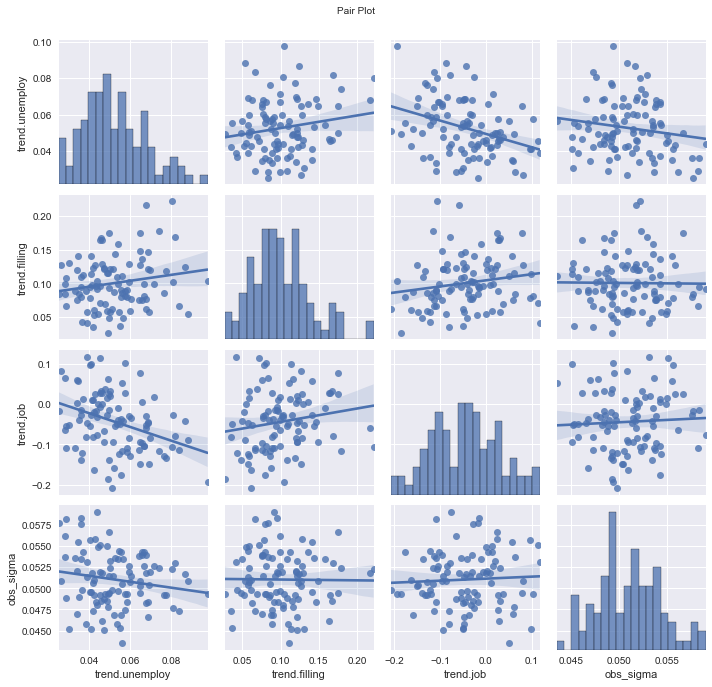

In [9]:
_ = plot_posterior_params(dlt_mcmc, kind='pair', pair_type='reg', 
                          incl_trend_params=False, incl_smooth_params=False)